# Text Mining project: Temporary Assistance for Needy Families (TANF)

In [ ]:
import lxml
import lxml.html
import requests
import pandas as pd
import csv
import time
import os
import re

## 1. Scraping dossiers from state legislature websites (Maine and Kansas)

First, I scrape documents on TANF from state legislature websites. I would like to get documents of all the states. But I find that there are very few files on TANF in some states when I search on more than 20 websites. Therefore, I focus on documents of Maine, which has many bill and testimony files. As I tried in homework 1, I can make use of API to get the files. I extend the duration to the last five legislatures.

In [50]:
tanf_list = []
n_testimony = 0
flag = 0
flag2 = 0

for i in range(125,129): # for the last 5 legislatures
    r = requests.get("http://legislature.maine.gov/backend/breeze/data/getCommitteeBills?legislature={}&committeeCode=HHS".format(i)).json()
    p = len(tanf_list)
    
    for d in r:
        if "TANF" in d['Request_Title']:
            tanf_list.append(d)
            n_testimony += d['TestimonyCount']
        elif "Needy" in d['Request_Title']:
            tanf_list.append(d)
            n_testimony += d['TestimonyCount']
            
    with open('maine-bill.csv', 'a') as out_file: # the list of resolutions or bills
        writer = csv.DictWriter(out_file, ['nth', 'date', 'paper_number', 'title', 'url'])
        if flag == 0:
            writer.writeheader()
            flag = 1

        for d in tanf_list[p:]:
            attributes = {}
            attributes["nth"] = str(i)
            attributes["date"] = d["Request_LatestCommitteeActionDate"]
            attributes["paper_number"] = d["Request_PaperNumber"]
            attributes["title"] = d["Request_Title"] 
            attributes["url"] = "http://legislature.maine.gov/bills/getPDF.asp?paper={}&item=1&snum={}".format(d["Request_PaperNumber"], str(i))
            writer.writerow(attributes) 
    
    with open('maine-testimony.csv', 'a') as out_file: # the list of testimonies
        writer = csv.DictWriter(out_file, ['nth', 'bill', 'date', 'id', 'name', 'organization', 'url'])
        if flag2 == 0:
            writer.writeheader()
            flag2 = 1

        for hp in tanf_list[p:]:
            url_test = "http://legislature.maine.gov/backend/breeze/data/CommitteeTestimony?$filter=(Request%2FPaperNumber%20eq%20%27{}%27)%20and%20(Request%2FLegislature%20eq%20{})&$orderby=LastName%2CFirstName%2COrganization&$expand=Request&$select=Id%2CFileType%2CNamePrefix%2CFirstName%2CLastName%2COrganization%2CPresentedDate%2CFileSize%2CTopic".format(hp["Request_PaperNumber"], str(i))
            r1 = requests.get(url_test).json()
        
            for d in r1:
                attributes = {}
                attributes["nth"] = str(i)
                attributes["bill"] = hp["Request_PaperNumber"]
                attributes["date"] = d["PresentedDate"]
                attributes["id"] = d["Id"]
                if d["LastName"] == None:
                    attributes["name"] = d["FirstName"]
                else:
                    attributes["name"] = d["FirstName"] + " " + d["LastName"]
                attributes["organization"] = d["Organization"]
                attributes["url"] = "http://legislature.maine.gov/backend/app/services/getDocument.aspx?doctype=test&documentId={}".format(d["Id"])
                writer.writerow(attributes)
    
print(n_testimony)
print(len(tanf_list))

177
18


Maine has 177 testimony documents and 18 bills. Their titles and URLs of PDF files are shown in the following tables. I save them and convert them into .txt files with the pdftotext command.

In [52]:
df = pd.read_csv("maine-bill.csv")
df2 = pd.read_csv("maine-testimony.csv")

In [54]:
df.head()

,nth,date,paper_number,title,url
0,126,2014-04-01T17:30:05.310,HP1312,An Act To Increase Integrity in the Temporary ...,http://legislature.maine.gov/bills/getPDF.asp?...
1,126,2014-04-01T17:29:19.127,HP1317,An Act To Require the Department of Health and...,http://legislature.maine.gov/bills/getPDF.asp?...
2,126,2014-04-01T17:28:29.157,HP1324,An Act To Amend the Laws Governing the Tempora...,http://legislature.maine.gov/bills/getPDF.asp?...
3,126,2014-04-01T17:27:50.027,HP1302,An Act To Require a Work Search for Job-ready ...,http://legislature.maine.gov/bills/getPDF.asp?...
4,126,2014-04-01T16:32:44.267,HP1309,"Resolve, Directing the Department of Health an...",http://legislature.maine.gov/bills/getPDF.asp?...


In [55]:
df2.head()

,nth,bill,date,id,name,organization,url
0,126,HP1312,2014-03-25T00:00:00.000,16079,Kandie Desell,Maine Association of Interdependent Neighborhoods,http://legislature.maine.gov/backend/app/servi...
1,126,HP1312,2014-03-25T00:00:00.000,16093,Jim Devine,Homeless Voices for Justice,http://legislature.maine.gov/backend/app/servi...
2,126,HP1312,2014-03-25T00:00:00.000,16074,Amy Regan Gallant,Preble Street,http://legislature.maine.gov/backend/app/servi...
3,126,HP1312,2014-03-25T00:00:00.000,16097,Danna Hayes,Maine Women's Lobby,http://legislature.maine.gov/backend/app/servi...
4,126,HP1312,2014-03-25T00:00:00.000,16089,Susan Lamb,National Association of Social Workers,http://legislature.maine.gov/backend/app/servi...


In [56]:
def downloadPDF(id_list, url_list):
    if len(id_list) != len(url_list):
        return print("The lengths of two lists are not the same.")   
    for i in range(len(id_list)):
        filename = "maine/" + str(id_list[i]) + ".pdf"
        r2 = requests.get(url_list[i])
        with open(filename, 'wb') as f:
            f.write(r2.content)

In [57]:
downloadPDF(df.paper_number, df.url)

In [58]:
downloadPDF(df2.id, df2.url)

Next, I download documents from Kansas legislature. However, Kansas has only one bill on TANF for the last three legislatures. I get all of testimony documents in the pages of "Health and Human Service at House" and "Public Health and Welfare committee at Senate" rather than filter by TANF. These files are later used to predict the positions (opponent or proponent) of TANF testimonies. Pdftotext cannot read several files of 438 PDF files since they do not have readable formats (like just images).

In [546]:
main_url = 'http://www.kslegislature.org/'
h_url = 'http://www.kslegislature.org/li/b2017_18/committees/ctte_h_hhs_1/'
s_url = 'http://www.kslegislature.org/li/b2017_18/committees/ctte_s_phw_1/'

response_h = requests.get(h_url)
response_s = requests.get(s_url)

tables_h = lxml.html.fromstring(response_h.text).cssselect('#main table')
tables_s = lxml.html.fromstring(response_s.text).cssselect('#main table')

bill_urls = []

def get_url(tables):
    for i in range(len(tables)):
        links = tables[i].cssselect('a')
        for link in links:
            bill_url = requests.compat.urljoin(main_url, link.attrib['href'])
            text = link.text_content()
            k = text.find("-")
            bill = text[0:(k-1)]
            bill_urls.append((bill_url, bill))

get_url(tables_h)
get_url(tables_s)

def get_url2(bill_url):
    response_b = requests.get(bill_url)
    link = ""
    l = lxml.html.fromstring(response_b.text).cssselect('#main p.bill_history_header > a')
    if len(l) > 0:
        link = l[0].attrib['href']
    else:
        return None
    testimony_url = requests.compat.urljoin(main_url, link)
    return testimony_url

testimony_urls = []

for bill_url, bill in bill_urls:
    testimony_urls.append((get_url2(bill_url), bill))
    time.sleep(2)

In [64]:
out = []
for testimony_url, bill in testimony_urls:
    if testimony_url != None:
        response_t = requests.get(testimony_url)
        t = lxml.html.fromstring(response_t.text)
        tables = t.cssselect('table')
        
        for i in range(len(tables)):
            for row_elem in tables[i].cssselect('tbody > tr'):
                attributes = {}
                children = row_elem.getchildren()
                attributes["bill"] = bill
                attributes["date"] = children[0].text_content()
                url = children[2].cssselect('a')[0].attrib['href']
                attributes["url"] = requests.compat.urljoin(main_url, url)
                attributes["name"] = children[3].text_content()
                attributes["position"] = children[5].text_content()
                if ("Opponent" in children[5].text_content()) | ("Proponent" in children[5].text_content()):
                    out.append(attributes)
                time.sleep(0.2)

In [66]:
len(out)

438

In [67]:
with open('kansas_testimony.csv', 'w') as out_file:
    writer = csv.DictWriter(out_file, ['bill', 'date', 'url', 'name', 'position'])
    writer.writeheader()
    for testimony in out:
            writer.writerow(testimony)

In [80]:
df_k = pd.read_csv("kansas_testimony.csv")
df_k["position_tf"] = df_k["position"].str.contains("Proponent")

In [97]:
def downloadPDF2(df):
    for i in range(len(df.index)):
        time.sleep(2)
        filename = "kansas/k" + str(i) + ".pdf"
        r = requests.get(df.url[i])
        with open(filename, 'wb') as f:
            f.write(r.content)

In [82]:
df_k.head()

,bill,date,url,name,position,position_tf
0,SB51,"Wed, Mar 8, 2017",http://www.kslegislature.org/li/b2017_18/commi...,Katie Whisman,Proponent,True
1,SB51,"Wed, Mar 8, 2017",http://www.kslegislature.org/li/b2017_18/commi...,Alexandra Blasi,Proponent,True
2,SB52,"Wed, Mar 8, 2017",http://www.kslegislature.org/li/b2017_18/commi...,Nick Reinecker,Opponent,False
3,SB52,"Wed, Mar 8, 2017",http://www.kslegislature.org/li/b2017_18/commi...,Katie Whisman,Proponent,True
4,SB52,"Wed, Mar 8, 2017",http://www.kslegislature.org/li/b2017_18/commi...,Alexandra Blasi,Proponent,True


In [ ]:
downloadPDF2(df_k)

In [548]:
len(df_k)

438

## 2. Overview of the corpus 

In [590]:
import nltk
from nltk.corpus import *
from nltk.corpus import wordnet as wn
from textwrap import fill
from collections import defaultdict
import pylab
import random
from sklearn.feature_extraction.text import TfidfVectorizer
%pylab inline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

Populating the interactive namespace from numpy and matplotlib


/Users/Owner/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'pylab', 'random', 'dist', 'fill', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


I have two methods to tokenize the text files. After reading them by PlaintextCorpusReader, I can get a list of words by documents.words(fileid) or nltk.word_tokenize(documents.raw(fileid)) as well as sentence tokenize.

In [240]:
corpus_root = './Maine'
documents = PlaintextCorpusReader(corpus_root, '.*\.txt')

In [187]:
corpus_root_k = './kansas'
documents_k = PlaintextCorpusReader(corpus_root_k, '.*\.txt')

In [552]:
documents.words(documents.fileids()[5])

['STATE', 'QF', 'MAINE', 'HOUSE', 'or', ...]

In [553]:
nltk.word_tokenize(documents.raw(documents.fileids()[5]))

['STATE',
 'QF',
 'MAINE',
 'HOUSE',
 'or',
 'REPRESENTATIVES',
 'HOUSE',
 'REPUBLICAN',
 '011131013',
 'E',
 '.',
 ';',
 'AUGUSTA',
 ',',
 'MAINE',
 '04333-0002',
 '3',
 'KENNETH',
 'WADE',
 'FREDETTE',
 'HOUSE',
 'REPUBLICAN',
 '‘',
 'LEADER',
 '-',
 'E-M',
 'a',
 'A',
 '_',
 '1',
 '1',
 ':',
 'f1edlaw',
 '@',
 '1nyfa11po1nt',
 'net',
 'Testimony',
 'of',
 'House',
 'Republican',
 'Leader',
 'Ken',
 'Fredette',
 'In',
 'Support',
 'LD',
 '1815',
 ',',
 'Of',
 '“',
 'An',
 'Act',
 'To',
 'Require',
 'a',
 'Work',
 'Search',
 'for',
 'Job-ready',
 'Applicants',
 'for',
 'Beneﬁts',
 'under',
 'the',
 'Temporary',
 'Assistance',
 'for',
 'Needy',
 'Families',
 'Program.',
 '”',
 'members',
 'of',
 'the',
 'Health',
 'and',
 'Human',
 'Services',
 'as',
 'the',
 'House',
 'Republican',
 'Leader',
 'and',
 'am',
 'proud',
 'Senator',
 'Craven',
 ',',
 'Representative',
 'Farnsworth',
 ',',
 'and',
 'Committee',
 '.',
 'represent',
 'My',
 'name',
 'is',
 'Ken',
 'F',
 'redette',
 '.',
 'Ho

Each document has thousands of words, and the distribution of the number is as below.

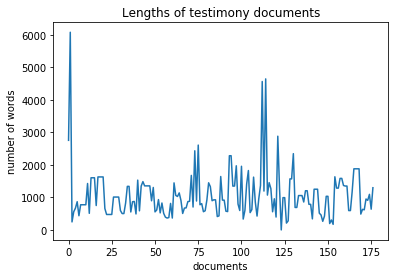

In [555]:
tes_length =[len(documents.words(fileid)) for fileid in documents.fileids()[:-18]]
tes_num = range(len(documents.fileids()[:-18]))
pylab.plot(tes_num, tes_length)
pylab.title('Lengths of testimony documents')
pylab.xlabel('documents')
pylab.ylabel('number of words')
pylab.savefig('testimony_length.png', dpi=300)

In [560]:
print(max(tes_length))
print(mean(tes_length))
print(min(tes_length))

6081
1081.83050847
0


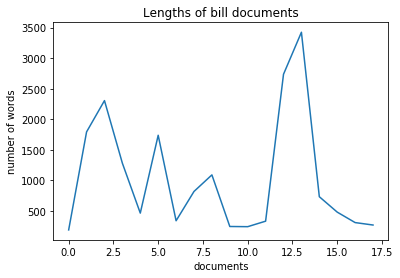

In [556]:
bill_length =[len(documents.words(fileid)) for fileid in documents.fileids()[-18:]]
bill_num = range(len(documents.fileids()[-18:]))
pylab.plot(bill_num, bill_length)
pylab.title('Lengths of bill documents')
pylab.xlabel('documents')
pylab.ylabel('number of words')
pylab.savefig('bill_length.png', dpi=300)

In [558]:
mean(bill_length)

1044.2222222222222

Frequent words are shown in the word cloud and the top 20 ranking.

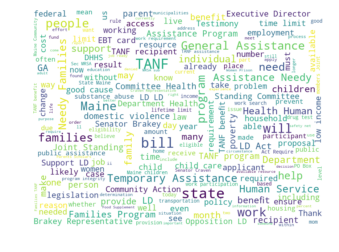

In [561]:
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'black'

wordcloud = WordCloud(max_font_size=40, background_color="white", width = 800, height = 600).generate(' '.join(documents.words()))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('WordCloud.png', dpi=300)

In [562]:
stopwords = nltk.corpus.stopwords.words('english')

In [566]:
print(nltk.FreqDist(w.lower() for w in documents.words() if w not in stopwords if len(w) > 2).most_common(20)) # top 20 words

[('tanf', 1396),
 ('assistance', 1250),
 ('families', 1144),
 ('maine', 1126),
 ('program', 1004),
 ('work', 792),
 ('would', 785),
 ('the', 760),
 ('state', 664),
 ('services', 559),
 ('people', 545),
 ('children', 542),
 ('department', 478),
 ('act', 468),
 ('health', 464),
 ('bill', 455),
 ('time', 451),
 ('this', 416),
 ('human', 392),
 ('support', 386)]

The agenda words of bills appear as shown in the dispersion plot. These words cover almost all the documents.

In [567]:
text = nltk.Text(documents.words())
text.collocations() # frequent bigrams

Needy Families; Temporary Assistance; General Assistance; Human
Services; Joint Standing; domestic violence; Executive Director; good
cause; Families Program; Standing Committee; Senator Brakey; Community
Action; child care; general assistance; http ://; Senator Craven; EBT
cards; safety net; department shall; substance abuse


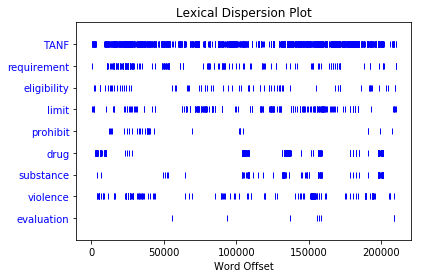

<Figure size 432x288 with 0 Axes>

In [571]:
text.dispersion_plot(["TANF", "requirement", "eligibility", "limit", "prohibit", "drug", "substance", "violence", "evaluation"])
pylab.savefig('dispersion_plot.png')

The bill documents have summary parts, so I extract them. The contents are incosistent with the above words.

In [572]:
dic = {}
bill_words = []
for i in range(1,19):
    position = 0
    summary = []
    sents = documents.sents(documents.fileids()[-i])
    for sent in sents:
        if sent[0] == "SUMMARY":
            position = position + 2
            while position < len(sents)-1:
                summary.extend(sents[position])
                position += 1
            break
        position += 1
    bill_words.extend(summary)
    dic[documents.fileids()[-i][:6]] = " ".join(summary)

In [573]:
dic

{'SP0181': 'This bill creates a work search requirement for job - ready applicants to the Temporary Assistance for Needy Families program .',
 'SP0136': 'This bill provides that a person who has exhausted the 60 - month lifetime limit on Temporary Assistance for Needy Families program benefits is ineligible to receive municipal general assistance program benefits .',
 'SP0066': 'This bill provides that a person who has exhausted the 60 - month lifetime limit on Temporary Assistance for Needy Families program benefits is ineligible to receive municipal general assistance program benefits except that a person who has been ineligible to receive benefits under the Temporary Assistance for Needy Families program for 5 or more years may be considered eligible and a person who is in the process of seeking an extension of benefits under the Temporary Assistance for Needy Families program may be considered eligible .',
 'SP0012': 'This bill changes the lifetime limit for receiving benefits thro

In [574]:
dfs = df.set_index("paper_number")
for (key, value) in dic.items():
    dfs.loc[key, "summary"] = value

## 3. Predict the positions of testimonies on TANF

I train Naive Bayes classifier with the data of Kansas legislature, and predict whether the testimony on TANF is a Proponent or a opponent. I have 438 documents from Kansas, and 351 are proponents.

In [192]:
print(len(df_k))
print(sum(df_k.position_tf))

438
351


In [201]:
kansas_set = [(list(documents_k.words("k"+str(i)+".pdf.txt")), df_k.position_tf[i]) for i in range(len(documents_k.fileids()))]
random.shuffle(kansas_set)

In [203]:
kansas_subset = [(words, position) for (words, position) in kansas_set if len(words)>10]

In [204]:
len(kansas_set)

434

In [205]:
len(kansas_subset) # 279 have any words. The others have no words because the texts are not readable on them.

279

In [209]:
sum(position for (words, position) in kansas_set if len(words)>10)

219

In [215]:
all_words = nltk.FreqDist(w.lower() for w in documents_k.words()).most_common()

In [585]:
word_features = [w for (w, n) in all_words if w not in stopwords if len(w)>2][:200]

In [586]:
def document_features(document): 
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [587]:
featuresets = [(document_features(d), c) for (d,c) in kansas_subset]
train_set, test_set = featuresets[25:], featuresets[:25]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [588]:
print(nltk.classify.accuracy(classifier, test_set))

0.88


In [589]:
classifier.show_most_informative_features(7)

Most Informative Features
    contains(palliative) = True            False : True   =      5.6 : 1.0
    contains(anesthesia) = True            False : True   =      4.6 : 1.0
       contains(support) = False           False : True   =      3.9 : 1.0
       contains(kancare) = True            False : True   =      3.3 : 1.0
       contains(dentist) = True             True : False  =      3.0 : 1.0
     contains(therapist) = True             True : False  =      3.0 : 1.0
       contains(support) = True             True : False  =      2.9 : 1.0


In [238]:
classifier.classify_many(d for (d, c) in featuresets[:5])

[True, False, False, True, False]

In [242]:
maine_features = [document_features(documents.words(fileid)) for fileid in documents.fileids()[:-18]]

In [246]:
classifier.classify_many(maine_features)

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 Tru

## 4. Summarize each testimony document on TANF

I try three types of summarization. The first one uses sentences tokenized by documents.sents(i) and computes the score by sum of frequency of words of the sentences and bill documents. The second one uses sentences tokenized by a different tokenizer. The third one computes the score by sum of tfidf. The last one's execution is very slow, so I apply it for just first three documents.

In [577]:
bill_pw = nltk.FreqDist(w.lower() for w in bill_words if w not in stopwords if len(w) > 2) # popular words in bills

In [579]:
def summarize(words, sents, n):
    """ Summarize the text by printing the n highest scoring sentences in the document order."""
    
    fdist = nltk.FreqDist(w.lower() for w in words) # count word frequencies
    
    d ={} # dictionary with position keys and word score values
    i = 0 # position index of a sentence
    for s in sents: 
        score = sum(fdist[w.lower()] + bill_pw[w.lower()]/18 for w in s if w not in stopwords) # generator expression to compute the score of total word frequency
        d[i] = score
        i += 1
    
    # the list with tuple elements ordered by score ranking
    ranking = sorted(d.items(), key = lambda x: -x[1]) 
    # the list of positions (indices) with n highest scoring sentences ordered by the original document positions
    position = sorted([t[0] for t in ranking][:n])
    
    for p in position:
        print(' '.join(sents[p]), "(sentence number:", p, ", score:", d[p], ")")

In [580]:
for i in documents.fileids()[:-18]:
    words = documents.words(i)
    sents = documents.sents(i)
    print("Summary of " + str(i) + " in testimony on TANF:")
    summarize(words, sents, n = 2)
    print("\n")

Summary of 10762.pdf.txt in testimony on TANF:
or exclude individuals from its municipal facilities , and / or in the delivery of its and services based on an individual person ‘ s race , ancestry , color , religion , gender , age , physical or mental For more information about this policy , contact or call Compliance disability , veteran status , or limited English speaking ability . (sentence number: 50 , score: 1738.8333333333335 )
The City of Lewiston does not discriminate against or exclude individuals from its municipal facilities , and / or in the delivery of its programs , activities and services based on an individual person ' s race , ancestry , color , religion , gender , age , physical or mental For more information about this policy , contact or call Compliance disability , veteran status , or limited English speaking ability . (sentence number: 110 , score: 2055.3888888888887 )


Summary of 10880.pdf.txt in testimony on TANF:
0 In New York State , 91 % of women receiving 

In [581]:
def summarize2(words, sents, n):
    """ Summarize the text by printing the n highest scoring sentences in the document order."""
    
    fdist = nltk.FreqDist(w.lower() for w in words) # count word frequencies
    
    d ={} # dictionary with position keys and word score values
    i = 0 # position index of a sentence
    for s in sents: 
        score = sum(fdist[w.lower()] + bill_pw[w.lower()]/18 for w in nltk.word_tokenize(s) if w not in stopwords) # generator expression to compute the score of total word frequency
        d[i] = score
        i += 1
    
    # the list with tuple elements ordered by score ranking
    ranking = sorted(d.items(), key = lambda x: -x[1]) 
    # the list of positions (indices) with n highest scoring sentences ordered by the original document positions
    position = sorted([t[0] for t in ranking][:n])
    
    for p in position:
        print(sents[p], "(sentence number:", p, ", score:", d[p], ")")

In [582]:
for i in documents.fileids()[:-18]:
    words = documents.words(i)
    sents = nltk.sent_tokenize(documents.raw(i).replace('\n',' '))
    print("Summary of " + str(i) + " in testimony on TANF:")
    summarize2(words, sents, n = 2)
    print("\n")

Summary of 10762.pdf.txt in testimony on TANF:
% Lewiston  Department Sue Charron  Social Services  All-Arnericaltily  '  -  ’  A  i  itsiiappening H8187  Social Services Director  i  I  H  I I  2007 Testimony of the City of Lewiston on LDs: 389; 598; 678; 892: 1343; 1411; 1416; 1443  May  g  3,  2013  Senator Craven, Representative Farnsworth, members of the Health and Human Services Committee, my name is Sue Charron, am the Social Services Director for the City of Lewiston, and am providing testimony in support of LDs 598; 892; and 1343 and in opposition to LDs: 389; .678; 1416; 1411; an1443 I  I  Support, with stipulations, LD 1343, An Act to Improve Readiness for Families Facing Significant Barriers to Employment. (sentence number: 0 , score: 2203.6111111111113 )
207-513-3130 Email: schnrr0n@ci.Iewist0n.me.us  Lewiston, -  '  Fax 207-376-3229  The City of Lewiston does not discriminate against or exclude individuals from its municipal facilities, and/or in the delivery of its progr

In [592]:
tes_corpus = []
index = []
for i in range(len(documents.fileids()[:-18])):
    filename = "Maine/" + documents.fileids()[i]
    f = open(filename)
    raw = f.read()
    tes_corpus.append(raw)
    index.append(documents.fileids()[i][:5])

In [591]:
vectorizer = TfidfVectorizer(min_df=1)
model = vectorizer.fit_transform(tes_corpus)
print(model.todense())

[[ 0.04578886  0.02107256  0.         ...,  0.          0.          0.        ]
 [ 0.          0.01978434  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.02511449 ...,  0.          0.          0.        ]
 [ 0.          0.          0.04307236 ...,  0.          0.          0.        ]
 [ 0.          0.          0.01957623 ...,  0.          0.          0.        ]]


In [593]:
tfidf_list = vectorizer.vocabulary_.keys()

In [583]:
def summarize3(words, sents, n, j):
    """ Summarize the text by printing the n highest scoring sentences in the document order."""
    
    
    d ={} # dictionary with position keys and word score values
    i = 0 # position index of a sentence
    for s in sents: 
        score = sum(model[j, vectorizer.vocabulary_[w]] for w in words if w not in stopwords if w in tfidf_list) # generator expression to compute the score of total word frequency
        d[i] = score
        i += 1
    
    # the list with tuple elements ordered by score ranking
    ranking = sorted(d.items(), key = lambda x: -x[1]) 
    # the list of positions (indices) with n highest scoring sentences ordered by the original document positions
    position = sorted([t[0] for t in ranking][:n])
    
    for p in position:
        print(sents[p], "(sentence number:", p, ", score:", d[p], ")")

In [584]:
j = 0
for i in documents.fileids()[:3]:
    words = documents.words(i)
    sents = nltk.sent_tokenize(documents.raw(i).replace('\n',' '))
    print("Summary of " + str(i) + " in testimony on TANF:")
    summarize3(words, sents, n = 2, j = j)
    print("\n")
    j += 1

Summary of 10762.pdf.txt in testimony on TANF:
% Lewiston  Department Sue Charron  Social Services  All-Arnericaltily  '  -  ’  A  i  itsiiappening H8187  Social Services Director  i  I  H  I I  2007 Testimony of the City of Lewiston on LDs: 389; 598; 678; 892: 1343; 1411; 1416; 1443  May  g  3,  2013  Senator Craven, Representative Farnsworth, members of the Health and Human Services Committee, my name is Sue Charron, am the Social Services Director for the City of Lewiston, and am providing testimony in support of LDs 598; 892; and 1343 and in opposition to LDs: 389; .678; 1416; 1411; an1443 I  I  Support, with stipulations, LD 1343, An Act to Improve Readiness for Families Facing Significant Barriers to Employment. (sentence number: 0 , score: 39.0273831904 )
improving services for ASPIRE-TANF participants by offering comprehensive screenings and referrals that will result in appropriate supports and benefits for families with disabilities and limitations is a step in the right dire

## 5. Primary Component Analysis

Finally, I try to apply topic model for the testimony documents. I select PCA as a demension reduction method, using three clusters. And I check cosine similarity and topic vectors.

In [434]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=tes_corpus).toarray()
tfidf_docs = pd.DataFrame(tfidf_docs, index=index)
tfidf_docs = tfidf_docs - tfidf_docs.mean()
tfidf_docs.shape

(177, 9615)

In [606]:
terms = tfidf.vocabulary_.keys()

In [609]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca = pca.fit(tfidf_docs)
pca_topic_vectors = pca.transform(tfidf_docs)
columns = ['topic{}'.format(i) for i in range(pca.n_components)]
pca_topic_vectors = pd.DataFrame(pca_topic_vectors, 
                                 columns=columns, index=index)
pca_topic_vectors.round(3).head()

,topic0,topic1,topic2
10762,-0.001,0.011,-0.121
10880,0.062,-0.046,-0.055
10881,0.022,-0.064,-0.035
10882,-0.149,-0.049,-0.175
10883,-0.013,0.011,-0.008


In [610]:
components = pd.DataFrame(pca.components_.T, index=terms, columns=columns)
components.round(2).head()

,topic0,topic1,topic2
%,-0.00,-0.00,-0.01
lewiston,0.01,-0.02,-0.01
department,0.00,-0.01,-0.06
sue,-0.00,-0.00,-0.00
charron,-0.00,-0.00,-0.00


In [611]:
import numpy as np

pca_topic_vectorst = (pca_topic_vectors.T / 
                     np.linalg.norm(pca_topic_vectors, axis=1)).T
pca_topic_vectorst.iloc[:6].dot(pca_topic_vectorst.iloc[:6].T).round(3)

,10762,10880,10881,10882,10883,16070
10762,1.000,0.531,0.387,0.727,0.472,-0.278
10880,0.531,1.000,0.863,0.117,-0.496,-0.677
10881,0.387,0.863,1.000,0.340,-0.501,-0.227
10882,0.727,0.117,0.340,1.000,0.622,0.440
10883,0.472,-0.496,-0.501,0.622,1.000,0.418
16070,-0.278,-0.677,-0.227,0.440,0.418,1.000


In [613]:
for i in range(pca.n_components):
    print(components.iloc[:,i].sort_values(ascending = False)[:15])

drugs                 0.295900
offering              0.270913
entire                0.129186
brunswick             0.104185
square                0.104185
month                 0.103954
paving                0.099111
track                 0.095154
disability-related    0.087257
initial               0.079361
homes                 0.066933
struggled             0.065071
h1epowerofsocicr      0.064636
focus                 0.063636
aspects               0.063472
Name: topic0, dtype: float64
offering              0.354143
entire                0.282921
track                 0.197417
disability-related    0.192764
_xjg                  0.165400
result                0.145653
h1epowerofsocicr      0.143785
struggled             0.133537
aspects               0.127249
oftheir               0.126662
initial               0.116523
burdened              0.115803
experiments           0.094424
fundamentally         0.092366
unavailable           0.087157
Name: topic1, dtype: float64
lgf         

If I add more clusters, explained variance of one component gradually decreases.

In [614]:
pca = PCA(n_components = 8)
pca = pca.fit(tfidf_docs)
pca_topic_vectors = pca.transform(tfidf_docs)
exvar = pca.explained_variance_ratio_ # saved at 

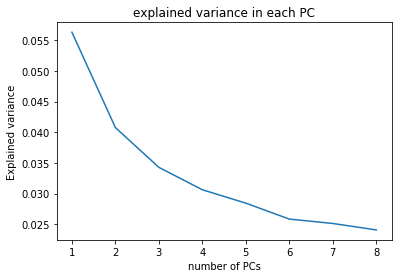

In [615]:
pca_num = range(1,9)
pylab.plot(pca_num, exvar)
pylab.title('explained variance in each PC')
pylab.xlabel('number of PCs')
pylab.ylabel('Explained variance')
pylab.savefig('PCA.png', dpi=300)